In [1]:
import scanpy as sc
import pickle as pkl
import pandas as pd
import numpy as np


from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

from cross_system_integration.model._xxjointmodel import XXJointModel


Global seed set to 0


In [7]:
path_ds='/om2/user/khrovati/data/cross_system_integration/retina_adult_organoid/'

In [8]:
adata=sc.read(path_ds+'combined_HVG.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 97996 × 1688
    obs: 'cell_type', 'cell_type_group', 'author_cell_type', 'condition', 'dataset', 'sample_id', 'ega_sample_alias', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'region', 'material', 'system'
    layers: 'counts'

## cVAE

In [10]:
adata_training = XXJointModel.setup_anndata(
    adata=adata,
    system_key='system',
    group_key=None,
    categorical_covariate_keys=['sample_id'],
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [13]:
# Train
model = XXJointModel(
    adata=adata_training,
    prior='standard_normal', 
)
model.train(max_epochs=40,
            log_every_n_steps=1,
            check_val_every_n_epoch=1,
            val_check_interval=1.0,  
            plan_kwargs={
                'loss_weights':{
                   'kl_weight':1,
                   'kl_cycle_weight':0,
                   'reconstruction_weight':1,
                   'reconstruction_mixup_weight':0,
                   'reconstruction_cycle_weight':0,
                   'z_distance_cycle_weight':0,
                   'translation_corr_weight':0,
                   'z_contrastive_weight':0,
               
           }})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/40:   0%|          | 0/40 [00:00<?, ?it/s]

/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_validation', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_pos_validation', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrasti

Epoch 40/40: 100%|██████████| 40/40 [23:51<00:00, 35.80s/it, loss=-947, v_num=1]


Epoch 1/70:   0%|          | 0/70 [24:14<?, ?it/s]


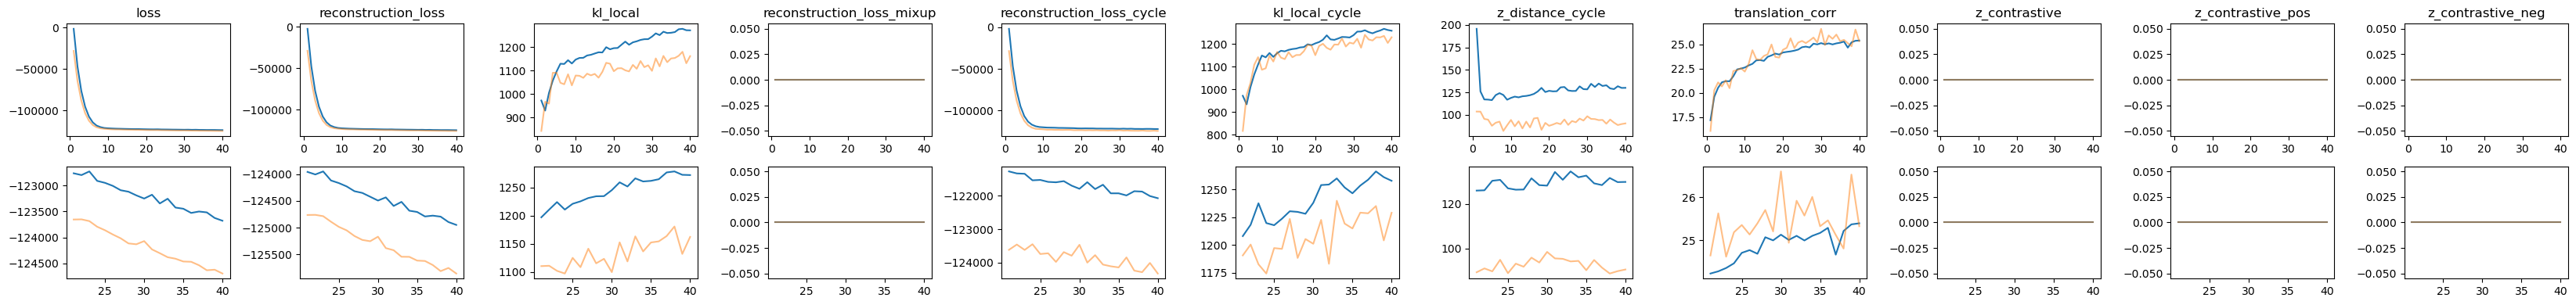

In [14]:
# Plot all loses
losses=[k for k in model.trainer.logger.history.keys() 
        if #'_step' not in k and '_epoch' not in k and 
        ('validation' not in k or 'eval' in k)]
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for wal leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently tyhis works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,20),
        (l_val_values,'tab:orange',0.5, 20)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

In [15]:
embed = model.embed(
        adata=adata_training,
        indices=None,
        batch_size=None,
        as_numpy=True)

embed=sc.AnnData(embed,obs=adata_training.obs)

In [16]:
# Use 90 neighbours so that this can be also used for lisi metrics
sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
sc.tl.umap(embed)

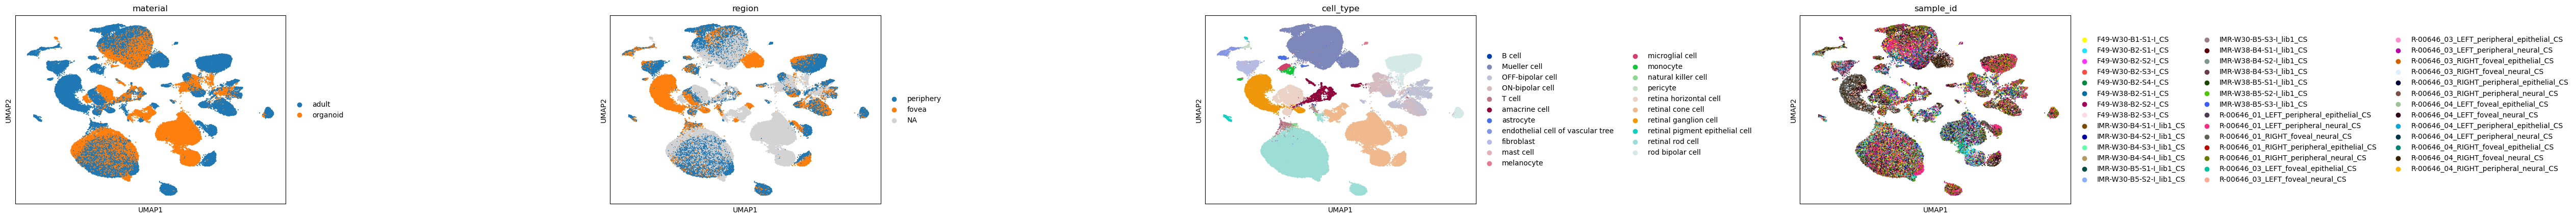

In [19]:
idxs=np.random.permutation(embed.obs_names)
sc.pl.umap(embed[idxs,:],color=['material','region','cell_type','sample_id',],
           s=10,sort_order=False,wspace=1)